LOCAL MAY 2024!!!

In [ ]:
import os
import pandas as pd
import re
import math
import requests  # Import requests module for HTTP requests
from urllib.parse import unquote

# Configuration
csv_file_path = 'C:/Users/alundkvi/Documents/work/data/auroraData/Filter_web_observation_may2024.csv'
output_file_base = 'C:/Users/alundkvi/Documents/work/data/auroraData/assetOutput/mayRenderbinMode/'
image_base_path = 'C:/Users/alundkvi/Documents/work/data/auroraData/mayImagesCompressed/'
user_assets_path = '${USER_ASSETS}/aurorasaurus/icons/newIcons2/'
user_assets_path_shapes = '${USER_ASSETS}/aurorasaurus/icons/newIcons3/'
not_seen_aurora_icon_path = '${USER_ASSETS}/aurorasaurus/icons/grayIcon.png'
default_icon_path = 'green2.png'
offset_step = 0.2  # Small offset step for adjusting positions
distance_threshold = 0.2
max_variables_per_file = 190  # Maximum number of local variables per file

# Define image paths based on colors
color_to_image_path = {
    'green': 'green2.png',
    'red': 'red2.png',
    'white': 'white2.png',
    'pink': 'pink2.png',
    'green,red': 'greenRed2.png',
    'green,white': 'greenWhite2.png',
    'green,pink': 'greenPink2.png',
    'green,red,white': 'greenRedWhite2.png',
    'green,pink,red': 'greenRedPink2.png',
    'green,pink,white': 'greenWhitePink2.png',
    'green,pink,red,white': 'greenRedWhitePink2.png',
    'red,white': 'redWhite2.png',
    'pink,red': 'redPink2.png',
    'pink,red,white': 'redWhitePink2.png',
    'pink,white': 'whitePink2.png'
}

""" color_to_image_path_camera = {
    'green': 'greenCamera.png',
    'red': 'redCamera.png',
    'white': 'whiteCamera.png',
    'pink': 'pinkCamera.png',
    'green,red': 'greenRedCamera.png',
    'green,white': 'greenWhiteCamera.png',
    'green,pink': 'greenPinkCamera.png',
    'green,red,white': 'greenRedWhiteCamera.png',
    'green,pink,red': 'greenRedPinkCamera.png',
    'green,pink,white': 'greenWhitePinkCamera.png',
    'green,pink,red,white': 'greenRedWhitePinkCamera.png',
    'red,white': 'redWhiteCamera.png',
    'pink,red': 'redPinkCamera.png',
    'pink,red,white': 'redWhitePinkCamera.png',
    'pink,white': 'whitePinkCamera.png'
} """

# Load data
df = pd.read_csv(csv_file_path)

# Ensure all_colors is a string and handle missing values
df['all_colors'] = df['all_colors'].fillna('').astype(str)

# Lua Template
lua_template = '''local {var_name} = {{
  Identifier = "{identifier}",
  Parent = earth.Earth.Identifier,
  TimeFrame = {{
    Type = "TimeFrameInterval",
    Start = "{start_time}",
    End = "{end_time}"
  }},
  Transform = {{
    Translation = {{
      Type = "GlobeTranslation",
      Globe = earth.Earth.Identifier,
      Latitude = {latitude},
      Longitude = {longitude},
      Altitude = {altitude},
      UseHeightmap = false
    }}
  }},
  Renderable = {{
    Type = "{renderable_type}",
    {renderable_details}
  }},
  GUI = {{
    Path = "/{gui_path}",
    Name = "{gui_name}"
  }}
}}

'''

# Function to write Lua script to file (modified for appending)
def write_lua_script(filename, lua_script, aurora_identifiers):
    earth_asset_code = 'local earth = asset.require("scene/solarsystem/planets/earth/earth")\n\n'

    earth_asset = "scene/solarsystem/planets/earth/earth"
    earth_asset_code = f'local earth = asset.require("{earth_asset}")\n\n'

    asset_management_code = "\n\nasset.onInitialize(function()\n"
    asset_management_code += ''.join([f"  openspace.addSceneGraphNode({identifier})\n" for identifier in aurora_identifiers])
    asset_management_code += "end)\n\n"

    asset_management_code += "asset.onDeinitialize(function()\n"
    asset_management_code += ''.join([f"  openspace.removeSceneGraphNode({identifier})\n" for identifier in aurora_identifiers])
    asset_management_code += "end)\n\n"

    asset_management_code += ''.join([f"asset.export({identifier})\n" for identifier in aurora_identifiers])

    final_lua_script = earth_asset_code + '\n'.join(lua_script) + asset_management_code

    # Append to file using 'a' mode to ensure appending
    with open(filename, 'a') as f:
        f.write(final_lua_script)

    print(f"Lua script generated and saved to {filename}")

# Function to generate Lua code
def generate_lua_code(var_name, identifier, start_time, end_time, latitude, longitude, altitude, renderable_type, renderable_details, gui_path, gui_name):
    return lua_template.format(
        var_name=var_name,
        identifier=identifier,
        start_time=start_time,
        end_time=end_time,
        latitude=latitude,
        longitude=longitude,
        altitude = altitude,
        renderable_type=renderable_type,
        renderable_details=renderable_details,
        gui_path=gui_path,
        gui_name=gui_name
    )

# Haversine formula to calculate the distance between two points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

# Function to adjust positions if they are within the distance threshold
def adjust_position(existing_positions, latitude, longitude):
    for (lat, lon) in existing_positions:
        if haversine(lat, lon, latitude, longitude) < distance_threshold:
            latitude += offset_step
            longitude += offset_step
    return latitude, longitude

# Initialize lists and counters
start_date = pd.Timestamp('2024-05-9').tz_localize(None)
end_date = pd.Timestamp('2024-05-13').tz_localize(None)
chunk_counter = 0
lua_scripts = []
aurora_identifiers = []

# Loop through DataFrame rows
for index, row in df.iterrows():
  
  time_start = pd.Timestamp(row['time_start']).tz_localize(None)
  if start_date <= time_start <= end_date:
      longitude, latitude = map(float, re.findall(r'[-]?\d+\.\d+', row['location']))

      # Adjust position if overlapping
      #latitude, longitude = adjust_position(existing_positions, latitude, longitude)
      #existing_positions.append((latitude, longitude))

      start_time = time_start.strftime('%Y %b %d %H:%M:%S')
      end_time = pd.to_datetime(row['time_end']).strftime('%Y %b %d %H:%M:%S')
      if not row['see_aurora']:
          var_name = f"notSeenAuroraIcon{index+1}"
          identifier = var_name
          icon_path = not_seen_aurora_icon_path
          altitude = 95000
          gui_name = f"Aurora not seen {index+1}"
          renderable_details = f'''Size = 75000,
  Origin = "Center",
  Billboard = true,
  Texture = "{icon_path}",
  Opacity = 1.0,
  Enabled = true,
  RenderBinMode = "PostDeferredTransparent"'''
          renderable_type = "RenderablePlaneImageLocal"
      else:
          colors = [c.strip().lower() for c in row['all_colors'].split(',')]

          # Join sorted colors to handle combinations correctly
          color_key = ','.join(sorted(colors))

          if not pd.isna(row['image']) and row['image'] != 'NA':
              var_name = f"shapeAurora{''.join([c.capitalize() for c in colors])}{index+1}"
              identifier = var_name
              image_name = f"image_{index+1}.{'jpg' if os.path.exists(os.path.join(image_base_path, f'image_{index+1}.jpg')) else 'png'}"
              icon_path = user_assets_path + color_to_image_path.get(color_key, default_icon_path)
              altitude = 120000
              gui_name = f"Aurora Image {index+1}"
              renderable_details = f'''Renderable1 = {{
        Type = "RenderablePlaneImageLocal",
        Size = 75000,
        Origin = "Center",
        Billboard = true,
        Texture = "{image_base_path}{image_name}",
        Opacity = 1,
        Enabled = true,
        RenderBinMode = "PostDeferredTransparent"
      }},
      Renderable2 = {{
        Type = "RenderablePlaneImageLocal",
        Size = 75000,
        Origin = "Center",
        Billboard = true,
        Texture = "{icon_path}",
        Opacity = 1,
        Enabled = true,
        RenderBinMode = "PostDeferredTransparent"
      }},
      DistanceThreshold = 1000000'''
              renderable_type = "RenderableSwitch"
          else:
              var_name = f"shapeIcon{''.join([c.capitalize() for c in colors])}{index+1}"
              identifier = var_name
              icon_path = user_assets_path + color_to_image_path.get(color_key, default_icon_path)
              gui_name = f"Time Frame Icon {' '.join([c.capitalize() for c in colors])} {index+1}"
              altitude = 100000
              renderable_details = f'''Size = 75000,
      Origin = "Center",
      Billboard = true,
      Texture = "{icon_path}",
      Opacity = 1.0,
      Enabled = true,
      RenderBinMode = "PostDeferredTransparent"'''
              renderable_type = "RenderablePlaneImageLocal"

      # Generate Lua code and append to lua_scripts
      lua_code = generate_lua_code(var_name, identifier, start_time, end_time, latitude, longitude, altitude, renderable_type, renderable_details.strip(), "Aurorasaurus/IconsWithoutImage" if row['image'] == 'NA' else "Aurorasaurus", gui_name)
      lua_scripts.append(lua_code)
      aurora_identifiers.append(identifier)

      # Check if we need to write lua_scripts to a new file
      if len(lua_scripts) >= max_variables_per_file:
          chunk_counter += 1
          filename = f"{output_file_base}{chunk_counter}.asset"
          write_lua_script(filename, lua_scripts, aurora_identifiers)
          # Reset lua_scripts and aurora_identifiers for the next chunk
          lua_scripts = []
          aurora_identifiers = []

# Write remaining lua_scripts to file if any
if lua_scripts:
    chunk_counter += 1
    filename = f"{output_file_base}{chunk_counter}.asset"
    write_lua_script(filename, lua_scripts, aurora_identifiers)



was ICON SWITCH

In [ ]:
import os
import pandas as pd
import re
import math
import requests  # Import requests module for HTTP requests
from urllib.parse import unquote

# Configuration
csv_file_path = 'C:/Users/alundkvi/Documents/work/data/auroraData/Filter_web_observation_may2024.csv'
output_file_base = 'C:/Users/alundkvi/Documents/work/data/auroraData/assetOutput/aurorasaurusMay2024Final/'
image_base_path = 'C:/Users/alundkvi/Documents/work/data/auroraData/mayImagesCompressed/'
user_assets_path = '${USER_ASSETS}/aurorasaurus/icons/newIcons2/'
user_assets_path_shapes = '${USER_ASSETS}/aurorasaurus/icons/newIcons3/'
not_seen_aurora_icon_path = '${USER_ASSETS}/aurorasaurus/icons/grayIcon.png'
default_icon_path = 'green2.png'
offset_step = 0.2  # Small offset step for adjusting positions
distance_threshold = 0.2
max_variables_per_file = 190  # Maximum number of local variables per file

# Define image paths based on colors
color_to_image_path = {
    'green': 'green2.png',
    'red': 'red2.png',
    'white': 'white2.png',
    'pink': 'pink2.png',
    'green,red': 'greenRed2.png',
    'green,white': 'greenWhite2.png',
    'green,pink': 'greenPink2.png',
    'green,red,white': 'greenRedWhite2.png',
    'green,pink,red': 'greenRedPink2.png',
    'green,pink,white': 'greenWhitePink2.png',
    'green,pink,red,white': 'greenRedWhitePink2.png',
    'red,white': 'redWhite2.png',
    'pink,red': 'redPink2.png',
    'pink,red,white': 'redWhitePink2.png',
    'pink,white': 'whitePink2.png'
}

color_to_image_path_camera = {
    'green': 'greenCamera.png',
    'red': 'redCamera.png',
    'white': 'whiteCamera.png',
    'pink': 'pinkCamera.png',
    'green,red': 'greenRedCamera.png',
    'green,white': 'greenWhiteCamera.png',
    'green,pink': 'greenPinkCamera.png',
    'green,red,white': 'greenRedWhiteCamera.png',
    'green,pink,red': 'greenRedPinkCamera.png',
    'green,pink,white': 'greenWhitePinkCamera.png',
    'green,pink,red,white': 'greenRedWhitePinkCamera.png',
    'red,white': 'redWhiteCamera.png',
    'pink,red': 'redPinkCamera.png',
    'pink,red,white': 'redWhitePinkCamera.png',
    'pink,white': 'whitePinkCamera.png'
} 

# Load data
df = pd.read_csv(csv_file_path)

# Ensure all_colors is a string and handle missing values
df['all_colors'] = df['all_colors'].fillna('').astype(str)

# Lua Template
lua_template = '''local {var_name} = {{
  Identifier = "{identifier}",
  Parent = earth.Earth.Identifier,
  TimeFrame = {{
    Type = "TimeFrameInterval",
    Start = "{start_time}",
    End = "{end_time}"
  }},
  Transform = {{
    Translation = {{
      Type = "GlobeTranslation",
      Globe = earth.Earth.Identifier,
      Latitude = {latitude},
      Longitude = {longitude},
      Altitude = {altitude},
      UseHeightmap = false
    }}
  }},
  Renderable = {{
    Type = "{renderable_type}",
    {renderable_details}
  }},
  GUI = {{
    Path = "/{gui_path}",
    Name = "{gui_name}"
  }}
}}

'''

# Function to write Lua script to file (modified for appending)
def write_lua_script(filename, lua_script, aurora_identifiers):
    earth_asset_code = 'local earth = asset.require("scene/solarsystem/planets/earth/earth")\n\n'

    earth_asset = "scene/solarsystem/planets/earth/earth"
    earth_asset_code = f'local earth = asset.require("{earth_asset}")\n\n'

    asset_management_code = "\n\nasset.onInitialize(function()\n"
    asset_management_code += ''.join([f"  openspace.addSceneGraphNode({identifier})\n" for identifier in aurora_identifiers])
    asset_management_code += "end)\n\n"

    asset_management_code += "asset.onDeinitialize(function()\n"
    asset_management_code += ''.join([f"  openspace.removeSceneGraphNode({identifier})\n" for identifier in aurora_identifiers])
    asset_management_code += "end)\n\n"

    asset_management_code += ''.join([f"asset.export({identifier})\n" for identifier in aurora_identifiers])

    final_lua_script = earth_asset_code + '\n'.join(lua_script) + asset_management_code

    # Append to file using 'a' mode to ensure appending
    with open(filename, 'a') as f:
        f.write(final_lua_script)

    print(f"Lua script generated and saved to {filename}")

# Function to generate Lua code
def generate_lua_code(var_name, identifier, start_time, end_time, latitude, longitude, altitude, renderable_type, renderable_details, gui_path, gui_name):
    return lua_template.format(
        var_name=var_name,
        identifier=identifier,
        start_time=start_time,
        end_time=end_time,
        latitude=latitude,
        longitude=longitude,
        altitude = altitude,
        renderable_type=renderable_type,
        renderable_details=renderable_details,
        gui_path=gui_path,
        gui_name=gui_name
    )

# Haversine formula to calculate the distance between two points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

# Function to adjust positions if they are within the distance threshold
def adjust_position(existing_positions, latitude, longitude):
    for (lat, lon) in existing_positions:
        if haversine(lat, lon, latitude, longitude) < distance_threshold:
            latitude += offset_step
            longitude += offset_step
    return latitude, longitude

# Initialize lists and counters
start_date = pd.Timestamp('2024-05-9').tz_localize(None)
end_date = pd.Timestamp('2024-05-13').tz_localize(None)
chunk_counter = 0
lua_scripts = []
aurora_identifiers = []

# Loop through DataFrame rows
for index, row in df.iterrows():
  
  time_start = pd.Timestamp(row['time_start']).tz_localize(None)
  if start_date <= time_start <= end_date:
      longitude, latitude = map(float, re.findall(r'[-]?\d+\.\d+', row['location']))

      # Adjust position if overlapping
      #latitude, longitude = adjust_position(existing_positions, latitude, longitude)
      #existing_positions.append((latitude, longitude))

      start_time = time_start.strftime('%Y %b %d %H:%M:%S')
      end_time = pd.to_datetime(row['time_end']).strftime('%Y %b %d %H:%M:%S')
      if not row['see_aurora']:
          #continue
          var_name = f"notSeenAuroraIcon{index+1}"
          identifier = var_name
          icon_path = not_seen_aurora_icon_path
          altitude = 95000
          gui_name = f"Aurora not seen {index+1}"
          renderable_details = f'''Size = 75000,
  Origin = "Center",
  Billboard = true,
  Texture = "{icon_path}",
  Opacity = 1.0,
  Enabled = true'''
          renderable_type = "RenderablePlaneImageLocal"
      else:
          colors = [c.strip().lower() for c in row['all_colors'].split(',')]

          # Join sorted colors to handle combinations correctly
          color_key = ','.join(sorted(colors))

          if not pd.isna(row['image']) and row['image'] != 'NA':
              var_name = f"Aurora{''.join([c.capitalize() for c in colors])}{index+1}"
              identifier = var_name
              image_name = f"image_{index+1}.{'jpg' if os.path.exists(os.path.join(image_base_path, f'image_{index+1}.jpg')) else 'png'}"
              icon_path = user_assets_path + color_to_image_path_camera.get(color_key, default_icon_path)
              altitude = 120000
              gui_name = f"Aurora Image {index+1}"
              renderable_details = f'''Renderable1 = {{
        Type = "RenderablePlaneImageLocal",
        Size = 75000,
        Origin = "Center",
        Billboard = true,
        Texture = "{image_base_path}{image_name}",
        Opacity = 1,
        Enabled = true
      }},
      Renderable2 = {{
        Type = "RenderablePlaneImageLocal",
        Size = 75000,
        Origin = "Center",
        Billboard = true,
        Texture = "{icon_path}",
        Opacity = 1,
        Enabled = true
      }},
      DistanceThreshold = 1000000'''
              renderable_type = "RenderableSwitch"
          else:
              var_name = f"icon{''.join([c.capitalize() for c in colors])}{index+1}"
              identifier = var_name
              icon_path = user_assets_path + color_to_image_path.get(color_key, default_icon_path)
              #icon_path2 = user_assets_path_shapes + color_to_image_path.get(color_key, default_icon_path)
              gui_name = f"Time Frame Icon {' '.join([c.capitalize() for c in colors])} {index+1}"
              altitude = 100000
              renderable_details = f'''Size = 75000,
      Origin = "Center",
      Billboard = true,
      Texture = "{icon_path}",
      Opacity = 1.0,
      Enabled = true'''
              renderable_type = "RenderablePlaneImageLocal"

      # Generate Lua code and append to lua_scripts
      lua_code = generate_lua_code(var_name, identifier, start_time, end_time, latitude, longitude, altitude, renderable_type, renderable_details.strip(), "Aurorasaurus/IconsWithoutImage" if row['image'] == 'NA' else "Aurorasaurus", gui_name)
      lua_scripts.append(lua_code)
      aurora_identifiers.append(identifier)

      # Check if we need to write lua_scripts to a new file
      if len(lua_scripts) >= max_variables_per_file:
          chunk_counter += 1
          filename = f"{output_file_base}{chunk_counter}.asset"
          write_lua_script(filename, lua_scripts, aurora_identifiers)
          # Reset lua_scripts and aurora_identifiers for the next chunk
          lua_scripts = []
          aurora_identifiers = []

# Write remaining lua_scripts to file if any
if lua_scripts:
    chunk_counter += 1
    filename = f"{output_file_base}{chunk_counter}.asset"
    write_lua_script(filename, lua_scripts, aurora_identifiers)



In [2]:
!pip install pandas

   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ------ --------------------------------- 1.8/11.6 MB 12.6 MB/s eta 0:00:01
   ---------------------------------------  11.5/11.6 MB 32.9 MB/s eta 0:00:01
   ---------------------------------------- 11.6/11.6 MB 21.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.9 MB ? eta -:--:--
   ------------------------- -------------- 10.2/15.9 MB 53.0 MB/s eta 0:00:01
   ---------------------------------------  15.7/15.9 MB 55.0 MB/s eta 0:00:01
   ---------------------------------------- 15.9/15.9 MB 31.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cartopy 0.23.0 requires matplotlib>=3.5, which is not installed.
pyogrio 0.9.0 requires certifi, which is not installed.


ICON SIZE DEPENDING ON DISTANCE

In [1]:
import os
import pandas as pd
import re
import math
#import requests  # Import requests module for HTTP requests
from urllib.parse import unquote

# Configuration
csv_file_path = 'C:/Users/alundkvi/Documents/work/data/auroraData/Filter_web_observation_may2024.csv'
output_file_base = 'C:/Users/alundkvi/Documents/work/data/auroraData/assetOutput/aurorasaurusMay2024SizeSwitch/'
image_base_path = 'C:/Users/alundkvi/Documents/work/data/auroraData/mayImagesCompressed/'
user_assets_path = '${USER_ASSETS}/aurorasaurus/icons/newIcons2/'
user_assets_path_shapes = '${USER_ASSETS}/aurorasaurus/icons/newIcons3/'
not_seen_aurora_icon_path = '${USER_ASSETS}/aurorasaurus/icons/grayIcon.png'
default_icon_path = 'green2.png'
offset_step = 0.2  # Small offset step for adjusting positions
distance_threshold = 0.2
max_variables_per_file = 190  # Maximum number of local variables per file

# Define image paths based on colors
color_to_image_path = {
    'green': 'green2.png',
    'red': 'red2.png',
    'white': 'white2.png',
    'pink': 'pink2.png',
    'green,red': 'greenRed2.png',
    'green,white': 'greenWhite2.png',
    'green,pink': 'greenPink2.png',
    'green,red,white': 'greenRedWhite2.png',
    'green,pink,red': 'greenRedPink2.png',
    'green,pink,white': 'greenWhitePink2.png',
    'green,pink,red,white': 'greenRedWhitePink2.png',
    'red,white': 'redWhite2.png',
    'pink,red': 'redPink2.png',
    'pink,red,white': 'redWhitePink2.png',
    'pink,white': 'whitePink2.png'
}

color_to_image_path_camera = {
    'green': 'greenCamera.png',
    'red': 'redCamera.png',
    'white': 'whiteCamera.png',
    'pink': 'pinkCamera.png',
    'green,red': 'greenRedCamera.png',
    'green,white': 'greenWhiteCamera.png',
    'green,pink': 'greenPinkCamera.png',
    'green,red,white': 'greenRedWhiteCamera.png',
    'green,pink,red': 'greenRedPinkCamera.png',
    'green,pink,white': 'greenWhitePinkCamera.png',
    'green,pink,red,white': 'greenRedWhitePinkCamera.png',
    'red,white': 'redWhiteCamera.png',
    'pink,red': 'redPinkCamera.png',
    'pink,red,white': 'redWhitePinkCamera.png',
    'pink,white': 'whitePinkCamera.png'
} 

# Load data
df = pd.read_csv(csv_file_path)

# Ensure all_colors is a string and handle missing values
df['all_colors'] = df['all_colors'].fillna('').astype(str)

# Lua Template
lua_template = '''local {var_name} = {{
  Identifier = "{identifier}",
  Parent = earth.Earth.Identifier,
  TimeFrame = {{
    Type = "TimeFrameInterval",
    Start = "{start_time}",
    End = "{end_time}"
  }},
  Transform = {{
    Translation = {{
      Type = "GlobeTranslation",
      Globe = earth.Earth.Identifier,
      Latitude = {latitude},
      Longitude = {longitude},
      Altitude = {altitude},
      UseHeightmap = false
    }}
  }},
  Renderable = {{
    Type = "{renderable_type}",
    {renderable_details}
  }},
  GUI = {{
    Path = "/{gui_path}",
    Name = "{gui_name}"
  }}
}}

'''

# Function to write Lua script to file (modified for appending)
def write_lua_script(filename, lua_script, aurora_identifiers):
    earth_asset_code = 'local earth = asset.require("scene/solarsystem/planets/earth/earth")\n\n'

    earth_asset = "scene/solarsystem/planets/earth/earth"
    earth_asset_code = f'local earth = asset.require("{earth_asset}")\n\n'

    asset_management_code = "\n\nasset.onInitialize(function()\n"
    asset_management_code += ''.join([f"  openspace.addSceneGraphNode({identifier})\n" for identifier in aurora_identifiers])
    asset_management_code += "end)\n\n"

    asset_management_code += "asset.onDeinitialize(function()\n"
    asset_management_code += ''.join([f"  openspace.removeSceneGraphNode({identifier})\n" for identifier in aurora_identifiers])
    asset_management_code += "end)\n\n"

    asset_management_code += ''.join([f"asset.export({identifier})\n" for identifier in aurora_identifiers])

    final_lua_script = earth_asset_code + '\n'.join(lua_script) + asset_management_code

    # Append to file using 'a' mode to ensure appending
    with open(filename, 'a') as f:
        f.write(final_lua_script)

    print(f"Lua script generated and saved to {filename}")

# Function to generate Lua code
def generate_lua_code(var_name, identifier, start_time, end_time, latitude, longitude, altitude, renderable_type, renderable_details, gui_path, gui_name):
    return lua_template.format(
        var_name=var_name,
        identifier=identifier,
        start_time=start_time,
        end_time=end_time,
        latitude=latitude,
        longitude=longitude,
        altitude = altitude,
        renderable_type=renderable_type,
        renderable_details=renderable_details,
        gui_path=gui_path,
        gui_name=gui_name
    )

# Haversine formula to calculate the distance between two points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

# Function to adjust positions if they are within the distance threshold
def adjust_position(existing_positions, latitude, longitude):
    for (lat, lon) in existing_positions:
        if haversine(lat, lon, latitude, longitude) < distance_threshold:
            latitude += offset_step
            longitude += offset_step
    return latitude, longitude

# Initialize lists and counters
start_date = pd.Timestamp('2024-05-9').tz_localize(None)
end_date = pd.Timestamp('2024-05-13').tz_localize(None)
chunk_counter = 0
lua_scripts = []
aurora_identifiers = []

# Loop through DataFrame rows
for index, row in df.iterrows():
  
  time_start = pd.Timestamp(row['time_start']).tz_localize(None)
  if start_date <= time_start <= end_date:
      longitude, latitude = map(float, re.findall(r'[-]?\d+\.\d+', row['location']))

      # Adjust position if overlapping
      #latitude, longitude = adjust_position(existing_positions, latitude, longitude)
      #existing_positions.append((latitude, longitude))

      start_time = time_start.strftime('%Y %b %d %H:%M:%S')
      end_time = pd.to_datetime(row['time_end']).strftime('%Y %b %d %H:%M:%S')
      if not row['see_aurora']:
          #continue
          var_name = f"notSeenAuroraIcon{index+1}"
          identifier = var_name
          icon_path = not_seen_aurora_icon_path
          altitude = 95000
          gui_name = f"Aurora not seen {index+1}"
          renderable_details = f'''Size = 1,
    Origin = "Center",
    Billboard = true,
    Texture = "{icon_path}",
    Opacity = 1.0,
    Enabled = true,
    ScaleByDistance = true,
    ScaleRatio = 0.01,
    ScaleByDistanceMaxHeight = 200000,
    RenderBinMode = "PostDeferredTransparent",
    ScaleByDistanceMinHeight = 30000'''
          renderable_type = "RenderablePlaneImageLocal"
      else:
          colors = [c.strip().lower() for c in row['all_colors'].split(',')]

          # Join sorted colors to handle combinations correctly
          color_key = ','.join(sorted(colors))

          if not pd.isna(row['image']) and row['image'] != 'NA':
              var_name = f"Aurora{''.join([c.capitalize() for c in colors])}{index+1}"
              identifier = var_name
              image_name = f"image_{index+1}.{'jpg' if os.path.exists(os.path.join(image_base_path, f'image_{index+1}.jpg')) else 'png'}"
              icon_path = user_assets_path + color_to_image_path_camera.get(color_key, default_icon_path)
              altitude = 120000
              gui_name = f"Aurora Image {index+1}"
              renderable_details = f'''Renderable1 = {{
        Type = "RenderablePlaneImageLocal",
        Size = 50000,
        Origin = "Center",
        Billboard = true,
        Texture = "{image_base_path}{image_name}",
        Opacity = 1,
        Enabled = true
      }},
    Renderable2 = {{
      Type = "RenderablePlaneImageLocal",
      Size = 1,
      Origin = "Center",
      Billboard = true,
      Texture = "{icon_path}",
      Opacity = 1,
      Enabled = true,
      ScaleByDistance = true,
      ScaleRatio = 0.01,
      ScaleByDistanceMaxHeight = 200000,
      ScaleByDistanceMinHeight = 30000
    }},
    RenderBinMode = "PostDeferredTransparent",
    DistanceThreshold = 1000000'''
              renderable_type = "RenderableSwitch"
          else:
              var_name = f"icon{''.join([c.capitalize() for c in colors])}{index+1}"
              identifier = var_name
              icon_path = user_assets_path + color_to_image_path.get(color_key, default_icon_path)
              #icon_path2 = user_assets_path_shapes + color_to_image_path.get(color_key, default_icon_path)
              gui_name = f"Time Frame Icon {' '.join([c.capitalize() for c in colors])} {index+1}"
              altitude = 100000
              renderable_details = f'''Size = 1,
      Origin = "Center",
      Billboard = true,
      Texture = "{icon_path}",
      Opacity = 1.0,
      Enabled = true,
      ScaleByDistance = true,
      ScaleRatio = 0.01,
      ScaleByDistanceMaxHeight = 200000,
      RenderBinMode = "PostDeferredTransparent",
      ScaleByDistanceMinHeight = 30000'''
              renderable_type = "RenderablePlaneImageLocal"

      # Generate Lua code and append to lua_scripts
      lua_code = generate_lua_code(var_name, identifier, start_time, end_time, latitude, longitude, altitude, renderable_type, renderable_details.strip(), "Aurorasaurus/IconsWithoutImage" if row['image'] == 'NA' else "Aurorasaurus", gui_name)
      lua_scripts.append(lua_code)
      aurora_identifiers.append(identifier)

      # Check if we need to write lua_scripts to a new file
      if len(lua_scripts) >= max_variables_per_file:
          chunk_counter += 1
          filename = f"{output_file_base}{chunk_counter}.asset"
          write_lua_script(filename, lua_scripts, aurora_identifiers)
          # Reset lua_scripts and aurora_identifiers for the next chunk
          lua_scripts = []
          aurora_identifiers = []

# Write remaining lua_scripts to file if any
if lua_scripts:
    chunk_counter += 1
    filename = f"{output_file_base}{chunk_counter}.asset"
    write_lua_script(filename, lua_scripts, aurora_identifiers)



Lua script generated and saved to C:/Users/alundkvi/Documents/work/data/auroraData/assetOutput/aurorasaurusMay2024SizeSwitch/1.asset
Lua script generated and saved to C:/Users/alundkvi/Documents/work/data/auroraData/assetOutput/aurorasaurusMay2024SizeSwitch/2.asset
Lua script generated and saved to C:/Users/alundkvi/Documents/work/data/auroraData/assetOutput/aurorasaurusMay2024SizeSwitch/3.asset
Lua script generated and saved to C:/Users/alundkvi/Documents/work/data/auroraData/assetOutput/aurorasaurusMay2024SizeSwitch/4.asset
Lua script generated and saved to C:/Users/alundkvi/Documents/work/data/auroraData/assetOutput/aurorasaurusMay2024SizeSwitch/5.asset
Lua script generated and saved to C:/Users/alundkvi/Documents/work/data/auroraData/assetOutput/aurorasaurusMay2024SizeSwitch/6.asset
Lua script generated and saved to C:/Users/alundkvi/Documents/work/data/auroraData/assetOutput/aurorasaurusMay2024SizeSwitch/7.asset
Lua script generated and saved to C:/Users/alundkvi/Documents/work/da

In [7]:
%pip install PyOpenGL


   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ----------------- ---------------------- 1.0/2.4 MB 4.6 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 6.9 MB/s eta 0:00:00


In [1]:
%pip install h5py

   ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.0 MB ? eta -:--:--
   -------------------- ------------------- 1.6/3.0 MB 5.2 MB/s eta 0:00:01
   ---------------------------------- ----- 2.6/3.0 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 3.0/3.0 MB 5.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
import h5py

def read_h5_file(file_path, dataset_name):
    with h5py.File(file_path, 'r') as h5_file:
        # Check if the specified dataset or group exists
        if dataset_name in h5_file:
            item = h5_file[dataset_name]
            if isinstance(item, h5py.Dataset):
                # If it's a dataset, read it
                data = item[:]
                print(f"Data from '{dataset_name}':", data)
            elif isinstance(item, h5py.Group):
                # If it's a group, list its contents
                print(f"'{dataset_name}' is a group. Its contents are:")
                for sub_item_name in item:
                    sub_item = item[sub_item_name]
                    if isinstance(sub_item, h5py.Dataset):
                        print(f" - Dataset: {sub_item_name}")
                    else:
                        print(f" - Group: {sub_item_name}")
        else:
            print(f"Dataset or group '{dataset_name}' not found in the file.")


file_path = 'C:/Users/alundkvi/Downloads/mothers_day_storm_data_for_bea/mothers_day_storm_data_for_bea/grid_gillam/rgb/2024/05/11/ut07/20240511_0723_110km_MOSv001_grid_trex-rgb.h5'

# Replace 'data' or 'metadata' with the name of the dataset you want to read
dataset_name = 'data'  # Change this to 'metadata' if needed
read_h5_file(file_path, dataset_name)


'data' is a group. Its contents are:
 - Dataset: grid
 - Group: source_info
 - Dataset: timestamp


In [8]:
import h5py

def print_group_contents(group, group_name):
    print(f"'{group_name}' is a group. Its contents are:")
    for item_name in group:
        item = group[item_name]
        if isinstance(item, h5py.Dataset):
            print(f" - Dataset: {item_name}: {item[:]}")
        elif isinstance(item, h5py.Group):
            print(f" - Group: {item_name}")
            print_group_contents(item, item_name)  # Recursively print contents of the subgroup

def read_h5_file(file_path):
    with h5py.File(file_path, 'r') as h5_file:
        # List and print contents of 'metadata'
        if 'metadata' in h5_file:
            metadata_group = h5_file['metadata']
            print_group_contents(metadata_group, 'metadata')

        # List and print contents of 'data'
        if 'data' in h5_file:
            data_group = h5_file['data']
            print_group_contents(data_group, 'data')

file_path = 'C:/Users/alundkvi/Downloads/mothers_day_storm_data_for_bea/mothers_day_storm_data_for_bea/grid_gillam/rgb/2024/05/11/ut07/20240511_0723_110km_MOSv001_grid_trex-rgb.h5'
read_h5_file(file_path)

'metadata' is a group. Its contents are:
 - Dataset: file: []
 - Group: frame
'frame' is a group. Its contents are:
 - Dataset: frame0: []
 - Dataset: frame1: []
 - Dataset: frame10: []
 - Dataset: frame11: []
 - Dataset: frame12: []
 - Dataset: frame13: []
 - Dataset: frame14: []
 - Dataset: frame15: []
 - Dataset: frame16: []
 - Dataset: frame17: []
 - Dataset: frame18: []
 - Dataset: frame19: []
 - Dataset: frame2: []
 - Dataset: frame3: []
 - Dataset: frame4: []
 - Dataset: frame5: []
 - Dataset: frame6: []
 - Dataset: frame7: []
 - Dataset: frame8: []
 - Dataset: frame9: []
'data' is a group. Its contents are:
 - Dataset: grid: [[[[-999. -999. -999. ... -999. -999. -999.]
   [-999. -999. -999. ... -999. -999. -999.]
   [-999. -999. -999. ... -999. -999. -999.]]

  [[-999. -999. -999. ... -999. -999. -999.]
   [-999. -999. -999. ... -999. -999. -999.]
   [-999. -999. -999. ... -999. -999. -999.]]

  [[-999. -999. -999. ... -999. -999. -999.]
   [-999. -999. -999. ... -999. -999. -9

In [10]:
%pip install numpy matplotlib

   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.8 MB 1.7 MB/s eta 0:00:05
   ------ --------------------------------- 1.3/7.8 MB 2.2 MB/s eta 0:00:04
   --------- ------------------------------ 1.8/7.8 MB 2.4 MB/s eta 0:00:03
   ------------ --------------------------- 2.4/7.8 MB 2.5 MB/s eta 0:00:03
   ----------------- ---------------------- 3.4/7.8 MB 2.9 MB/s eta 0:00:02
   ---------------------- ----------------- 4.5/7.8 MB 3.2 MB/s eta 0:00:02
   ----------------------------- ---------- 5.8/7.8 MB 3.6 MB/s eta 0:00:01
   ------------------------------------- -- 7.3/7.8 MB 4.1 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 4.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   --------------------------------- ------ 1.8/2.2 MB 8.4 MB/s eta 0:00:01
   ------------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


TypeError: Invalid shape (1024, 3, 20) for image data

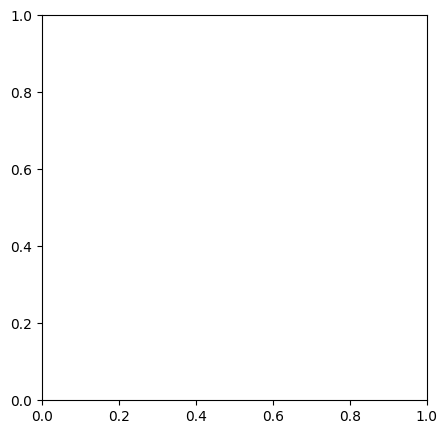

In [12]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

file_path = 'C:/Users/alundkvi/Downloads/mothers_day_storm_data_for_bea/mothers_day_storm_data_for_bea/grid_gillam/rgb/2024/05/11/ut07/20240511_0723_110km_MOSv001_grid_trex-rgb.h5'

with h5py.File(file_path, 'r') as f:
    grid_data = f['data/grid'][:]  # Adjust this path as needed
    
    # Access the timestamps
    timestamps = f['data/timestamp'][:]  # Adjust this path as needed

    for i in range(grid_data.shape[0]):  # Iterate through frames
        grid = grid_data[i]
        
        # If grid has shape (1024, 3, 20), select one channel or average
        # Option 1: Select the first channel
        # grid = grid[:, 0, :]  # Use this if you want to visualize one channel

        # Option 2: Average across the channels (if they are similar)
        grid = np.mean(grid, axis=1)  # Average over the second dimension

        plt.figure(figsize=(10, 5))
        plt.imshow(grid, cmap='viridis', interpolation='nearest')
        plt.colorbar(label='Value')  # Optional: add colorbar
        
        # Format the timestamp (adjust based on your data type)
        timestamp_str = str(timestamps[i])  # Convert timestamp to string if needed
        plt.title(f'Aurora Image for Timestamp: {timestamp_str}')
        
        # Save the image or display it
        plt.savefig(f'aurora_image_{i}.png')  # Save as PNG
        plt.show()  # Or just show the image
